Initial Balance: 10000.0
Final Balance: 12294.714001961735
Profit: 2294.7140019617345
Trades:
(Timestamp('2024-07-09 20:00:00'), 'BUY', np.float64(57248.7))
(Timestamp('2024-07-12 00:00:00'), 'SELL', np.float64(56878.6))
(Timestamp('2024-07-13 12:00:00'), 'BUY', np.float64(58280.8))
(Timestamp('2024-07-18 20:00:00'), 'SELL', np.float64(63707.5))
(Timestamp('2024-07-19 20:00:00'), 'BUY', np.float64(65830.5))
(Timestamp('2024-07-23 08:00:00'), 'SELL', np.float64(65760.0))
(Timestamp('2024-07-26 08:00:00'), 'BUY', np.float64(66300.0))
(Timestamp('2024-07-30 00:00:00'), 'SELL', np.float64(66500.0))
(Timestamp('2024-08-08 00:00:00'), 'BUY', np.float64(58010.0))
(Timestamp('2024-08-11 20:00:00'), 'SELL', np.float64(59374.8))
(Timestamp('2024-08-14 08:00:00'), 'BUY', np.float64(59322.0))
(Timestamp('2024-08-14 16:00:00'), 'SELL', np.float64(58364.2))
(Timestamp('2024-08-17 12:00:00'), 'BUY', np.float64(58699.8))
(Timestamp('2024-08-21 00:00:00'), 'SELL', np.float64(58000.0))
(Timestamp('2024-

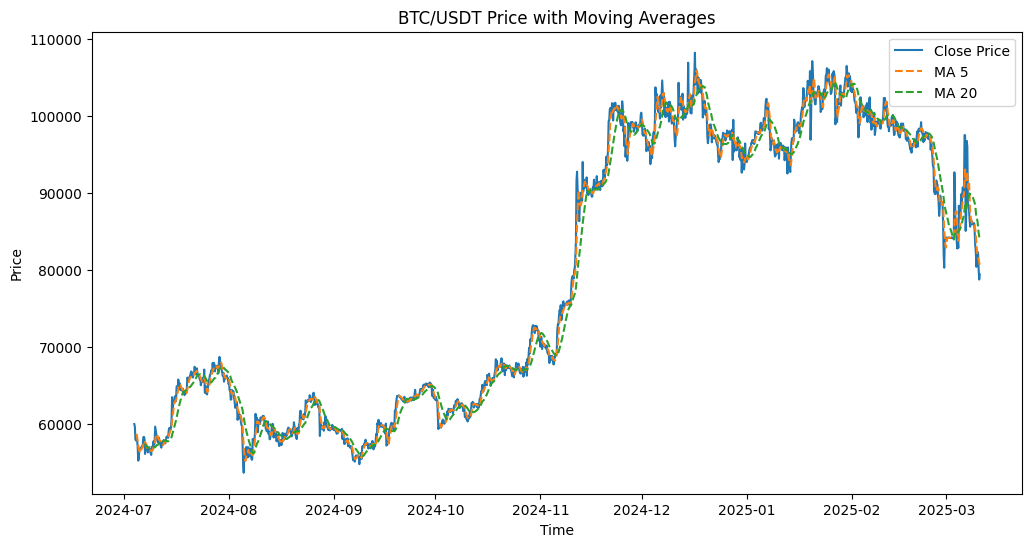

In [15]:
import sys
sys.path.append('../src')  # src 폴더를 import 경로에 추가

import pandas as pd
import matplotlib.pyplot as plt

from data_collector import create_exchange, fetch_ohlcv_data
from strategy import generate_signal

# 1) 충분히 긴 과거 데이터 수집 (Spot/선물 메인넷 등에서)
exchange = create_exchange()
# 예시: 'BTC/USDT', 1d(하루봉), 최근 200일치
df = exchange.fetch_ohlcv('BTC/USDT', timeframe='4h', limit=100000)
df = pd.DataFrame(df, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# 2) 백테스트 로직: 간단 이동평균 교차
initial_balance = 10000.0
balance = initial_balance
position = None
entry_price = 0
num_shares = 0
trades = []  # 매매 기록 저장

SHORT_WINDOW = 5
LONG_WINDOW = 20

# 이동평균 계산
df['ma_short'] = df['close'].rolling(SHORT_WINDOW).mean()
df['ma_long'] = df['close'].rolling(LONG_WINDOW).mean()

for i in range(LONG_WINDOW, len(df)):
    current_price = df.iloc[i]['close']
    short_ma = df.iloc[i]['ma_short']
    long_ma = df.iloc[i]['ma_long']
    
    # 직전 데이터
    prev_short_ma = df.iloc[i-1]['ma_short']
    prev_long_ma = df.iloc[i-1]['ma_long']
    
    # 매수 신호: 단기MA가 장기MA를 상향 돌파
    if prev_short_ma <= prev_long_ma and short_ma > long_ma:
        # 포지션이 없을 때만 매수
        if position is None:
            position = 'long'
            entry_price = current_price
            # 보유자금(balance)을 전부 사용한다고 가정 (단순화)
            num_shares = balance / current_price
            balance = 0
            trades.append((df.iloc[i]['timestamp'], 'BUY', current_price))

    # 매도 신호: 단기MA가 장기MA를 하향 돌파
    elif prev_short_ma >= prev_long_ma and short_ma < long_ma:
        # 현재 롱 포지션이 있다면 청산
        if position == 'long':
            # 주식/코인 전량 매도
            balance = num_shares * current_price
            num_shares = 0
            position = None
            trades.append((df.iloc[i]['timestamp'], 'SELL', current_price))

# 마지막에 포지션이 남아있다면 청산
if position == 'long':
    # 마지막 종가로 청산
    balance = num_shares * df.iloc[-1]['close']
    num_shares = 0
    position = None
    trades.append((df.iloc[-1]['timestamp'], 'FINAL_SELL', df.iloc[-1]['close']))

final_balance = balance
profit = final_balance - initial_balance

print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {final_balance}")
print(f"Profit: {profit}")
print("Trades:")
for t in trades:
    print(t)

# 시각화
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['close'], label='Close Price')
plt.plot(df['timestamp'], df['ma_short'], label=f'MA {SHORT_WINDOW}', linestyle='--')
plt.plot(df['timestamp'], df['ma_long'], label=f'MA {LONG_WINDOW}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('BTC/USDT Price with Moving Averages')
plt.legend()
plt.show()
